In [1]:
HQA_MNIST_SAVE_PATH = './checkpoints/hqa_mnist.pt'
CLASSIFIER_MNIST_SAVE_PATH = './checkpoints/lenet_mnist.pt'


In [2]:
import torch
import torchattacks
from torchvision.transforms import ToPILImage
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from data import reconstructWithJPEG

import os

from hqa_lightning import train_hqa_mnist, HQA2D_Lightning
from lenet5 import LeNet5
from data import get_mnist_dataloaders, get_preds


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)
dl_train, dl_test = get_mnist_dataloaders()

Device:  cuda


In [3]:
if os.path.exists(HQA_MNIST_SAVE_PATH):
    hqa_model = torch.load(HQA_MNIST_SAVE_PATH).to(device)
    print(f"Loaded {len(hqa_model)} layer model from checkpoint.")
else:
    hqa_model = train_hqa_mnist(max_epochs=50, devices=1)
    torch.save(hqa_model, HQA_MNIST_SAVE_PATH)

def reconstruct(layer, attack=None):
    def _reconstruct(x, y):
        if attack is not None:
            x = attack(x, y)
        if layer >= 0:
            x = x.to(hqa_model.device)
            x_recon = hqa_model[layer].reconstruct(x)
            return x_recon
        return x
    return _reconstruct

Loaded 5 layer model from checkpoint.


In [4]:
if os.path.exists(CLASSIFIER_MNIST_SAVE_PATH):
    lenet_model = torch.load(CLASSIFIER_MNIST_SAVE_PATH).to(device)
    print(f"Loaded MNIST classifier from checkpoint.")
else:
    print("Classifier checkpoint not found!")

Loaded MNIST classifier from checkpoint.


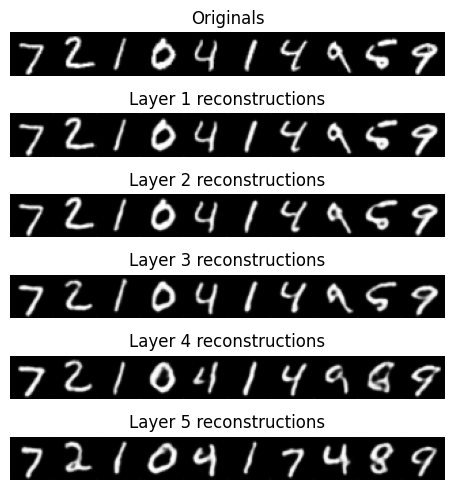

In [5]:
num_recons = 10

toImage = ToPILImage()

x, _ = next(iter(dl_test))
x = x[:num_recons]

originals = np.concatenate([toImage(img) for img in x], axis=1)
fig, ax = plt.subplots(ncols=1, nrows=len(hqa_model) + 1, figsize=(8,5))

ax[0].imshow(originals, cmap='gray')
ax[0].axis("off")
ax[0].set_title("Originals")

for layer_index, layer in enumerate(hqa_model):
    x = x.to(hqa_model.device)
    recons = layer.reconstruct(x)
    recons = recons.cpu()
    recons_img = np.concatenate([toImage(recon) for recon in recons], axis=1)
    
    ax[layer_index + 1].imshow(recons_img, cmap='gray')
    ax[layer_index+ 1].axis("off")
    ax[layer_index + 1].set_title(f"Layer {layer_index+1} reconstructions")

fig.tight_layout()
plt.show()

In [6]:
accuracies_no_attack = []
hqa_compression_ratios = [1,4,16,64,256,1024]
Y, Y_pred = get_preds(lenet_model, dl_test)
accuracy = accuracy_score(Y,Y_pred)
print("Original Data Classification Accuracy: ", accuracy)
accuracies_no_attack.append(accuracy)

for index, layer in enumerate(hqa_model):
    Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(index))
    accuracy = accuracy_score(Y,Y_pred)
    accuracies_no_attack.append(accuracy)
    print(f"Layer {index} Reconstructions Classification Accuracy: ", accuracy)

Original Data Classification Accuracy:  0.9903
Layer 0 Reconstructions Classification Accuracy:  0.9906
Layer 1 Reconstructions Classification Accuracy:  0.9856
Layer 2 Reconstructions Classification Accuracy:  0.9514
Layer 3 Reconstructions Classification Accuracy:  0.8475
Layer 4 Reconstructions Classification Accuracy:  0.7204


In [7]:
qualities = [100, 75, 50, 25, 0]

jpeg_compression_ratios = [1]
jpeg_accuracies_no_attack = []

def jpeg_reconstruct(quality=100):
    def _reconstruct(x, y):
        return reconstructWithJPEG(x, quality=quality)
    return _reconstruct

Y, Y_pred = get_preds(lenet_model, dl_test)
accuracy = accuracy_score(Y,Y_pred)
print("Original Data Classification Accuracy: ", accuracy)
jpeg_accuracies_no_attack.append(accuracy)

for index, quality in enumerate(qualities):
    Y, Y_pred = get_preds(lenet_model, dl_test, transform=jpeg_reconstruct(quality=quality))
    accuracy = accuracy_score(Y,Y_pred)
    jpeg_accuracies_no_attack.append(accuracy)
    print(f"JPEG Reconstructions Classification Accuracy: (quality={quality})", accuracy)
    _, ratio = reconstructWithJPEG(next(iter(dl_test))[0], quality=quality, return_ratio = True)
    print(f"Ratio: ", ratio)
    jpeg_compression_ratios.append(ratio)

Original Data Classification Accuracy:  0.9908


/home/armani/thesis/data.py:82: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(recs, dtype=torch.float32) / 255


JPEG Reconstructions Classification Accuracy: (quality=100) 0.9914
Ratio:  1.1906976744186046
JPEG Reconstructions Classification Accuracy: (quality=75) 0.9912
Ratio:  2.0357852882703775
JPEG Reconstructions Classification Accuracy: (quality=50) 0.9898
Ratio:  2.2555066079295156
JPEG Reconstructions Classification Accuracy: (quality=25) 0.9902
Ratio:  2.4265402843601898
JPEG Reconstructions Classification Accuracy: (quality=0) 0.9763
Ratio:  2.8444444444444446


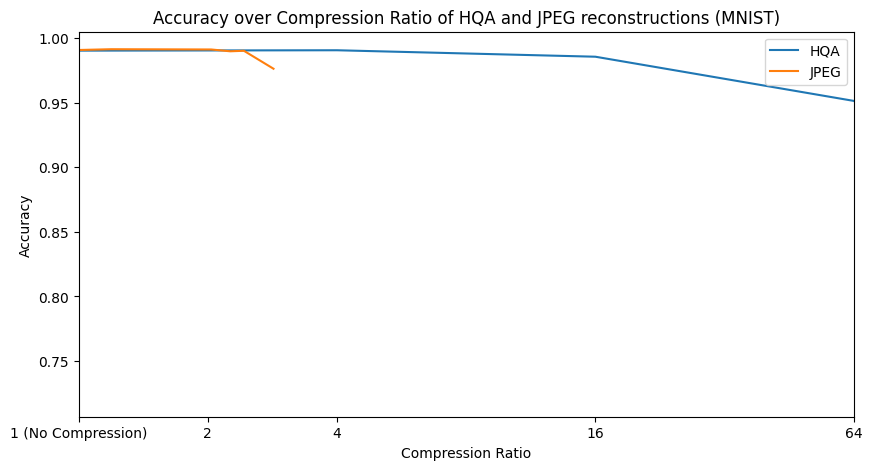

<Figure size 640x480 with 0 Axes>

In [8]:
plt.figure(figsize=[10,5])
plt.plot(hqa_compression_ratios, accuracies_no_attack, label="HQA")
plt.plot(jpeg_compression_ratios, jpeg_accuracies_no_attack, label="JPEG")
plt.xlim(right=64)
plt.xlim(left=1)
plt.legend()
plt.title("Accuracy over Compression Ratio of HQA and JPEG reconstructions (MNIST)")
plt.xscale('log', base=2)
plt.xticks([2] + hqa_compression_ratios[:4], labels=["2", "1 (No Compression)", "4", "16", "64"])
plt.ylabel("Accuracy")
plt.xlabel("Compression Ratio")
plt.show()
plt.savefig("./resources/MNIST_JPEG_HQA.png")

In [9]:
accuracies_fgsm_attack_01 = []
accuracies_fgsm_attack_05 = []
accuracies_fgsm_attack_07 = []
accuracies_fgsm_attack_10 = []
accuracies_fgsm_attack_20 = []

epsilons = [0.01, 0.05, 0.07, 0.1, 0.2]

eps_to_array = {
    0.01 : accuracies_fgsm_attack_01,
    0.05 : accuracies_fgsm_attack_05,
    0.07 : accuracies_fgsm_attack_07,
    0.1 : accuracies_fgsm_attack_10,
    0.2 : accuracies_fgsm_attack_20
}

for epsilon in epsilons:
    attack = torchattacks.FGSM(lenet_model, eps=epsilon)
    Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(-1, attack=attack))
    accuracy = accuracy_score(Y,Y_pred)
    print(f"Attack [FGSM eps={epsilon}] Accuracy: ", accuracy)
    eps_to_array[epsilon].append(accuracy)
    for index, layer in enumerate(hqa_model):
        Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(index, attack=attack))
        accuracy = accuracy_score(Y,Y_pred)
        eps_to_array[epsilon].append(accuracy)
        print(f"Layer {index} Reconstructions [FGSM eps={epsilon}] Accuracy: ", accuracy)

Attack [FGSM eps=0.01] Accuracy:  0.9788
Layer 0 Reconstructions [FGSM eps=0.01] Accuracy:  0.9871
Layer 1 Reconstructions [FGSM eps=0.01] Accuracy:  0.9852
Layer 2 Reconstructions [FGSM eps=0.01] Accuracy:  0.949
Layer 3 Reconstructions [FGSM eps=0.01] Accuracy:  0.8471
Layer 4 Reconstructions [FGSM eps=0.01] Accuracy:  0.717
Attack [FGSM eps=0.05] Accuracy:  0.8574
Layer 0 Reconstructions [FGSM eps=0.05] Accuracy:  0.9716
Layer 1 Reconstructions [FGSM eps=0.05] Accuracy:  0.9729
Layer 2 Reconstructions [FGSM eps=0.05] Accuracy:  0.9338
Layer 3 Reconstructions [FGSM eps=0.05] Accuracy:  0.8383
Layer 4 Reconstructions [FGSM eps=0.05] Accuracy:  0.7114
Attack [FGSM eps=0.07] Accuracy:  0.7719
Layer 0 Reconstructions [FGSM eps=0.07] Accuracy:  0.9526
Layer 1 Reconstructions [FGSM eps=0.07] Accuracy:  0.9623
Layer 2 Reconstructions [FGSM eps=0.07] Accuracy:  0.9161
Layer 3 Reconstructions [FGSM eps=0.07] Accuracy:  0.8229
Layer 4 Reconstructions [FGSM eps=0.07] Accuracy:  0.7105
Attack [F

In [10]:
accuracies_bim_attack_01 = []
accuracies_bim_attack_05 = []
accuracies_bim_attack_07 = []
accuracies_bim_attack_10 = []
accuracies_bim_attack_20 = []

epsilons = [0.01, 0.05, 0.07, 0.1, 0.2]
arrays = [accuracies_bim_attack_01, accuracies_bim_attack_05, accuracies_bim_attack_07, accuracies_bim_attack_10, accuracies_bim_attack_20]

# BIM Attack
for epsilon, array in zip(epsilons, arrays):
    attack = torchattacks.BIM(lenet_model, eps=epsilon, alpha=2/255, steps=10)
    Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(-1, attack=attack))
    accuracy = accuracy_score(Y,Y_pred)
    print(f"Attack [BIM eps={epsilon}] Accuracy: ", accuracy)
    array.append(accuracy)
    for index, layer in enumerate(hqa_model):
        Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(index, attack=attack))
        accuracy = accuracy_score(Y,Y_pred)
        array.append(accuracy)
        print(f"Layer {index} Reconstructions [BIM eps={epsilon}] Accuracy: ", accuracy)

Attack [BIM eps=0.01] Accuracy:  0.9778
Layer 0 Reconstructions [BIM eps=0.01] Accuracy:  0.9865
Layer 1 Reconstructions [BIM eps=0.01] Accuracy:  0.984
Layer 2 Reconstructions [BIM eps=0.01] Accuracy:  0.9489
Layer 3 Reconstructions [BIM eps=0.01] Accuracy:  0.8494
Layer 4 Reconstructions [BIM eps=0.01] Accuracy:  0.716
Attack [BIM eps=0.05] Accuracy:  0.6967
Layer 0 Reconstructions [BIM eps=0.05] Accuracy:  0.9697
Layer 1 Reconstructions [BIM eps=0.05] Accuracy:  0.9715
Layer 2 Reconstructions [BIM eps=0.05] Accuracy:  0.9335
Layer 3 Reconstructions [BIM eps=0.05] Accuracy:  0.8398
Layer 4 Reconstructions [BIM eps=0.05] Accuracy:  0.713
Attack [BIM eps=0.07] Accuracy:  0.5339
Layer 0 Reconstructions [BIM eps=0.07] Accuracy:  0.9525
Layer 1 Reconstructions [BIM eps=0.07] Accuracy:  0.9636
Layer 2 Reconstructions [BIM eps=0.07] Accuracy:  0.9265
Layer 3 Reconstructions [BIM eps=0.07] Accuracy:  0.8298
Layer 4 Reconstructions [BIM eps=0.07] Accuracy:  0.7105
Attack [BIM eps=0.1] Accurac

In [11]:
accuracies_pgd_attack_01 = []
accuracies_pgd_attack_05 = []
accuracies_pgd_attack_07 = []
accuracies_pgd_attack_10 = []
accuracies_pgd_attack_20 = []


overshoots = [0.01, 0.05, 0.07, 0.1, 0.2]
arrays = [accuracies_pgd_attack_01, accuracies_pgd_attack_05, accuracies_pgd_attack_07, accuracies_pgd_attack_10, accuracies_pgd_attack_20]

# pgd Attack
for overshoot, array in zip(overshoots, arrays):
    attack = torchattacks.PGD(lenet_model, eps=overshoot)
    x, y = next(iter(dl_test))
    Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(-1, attack=attack))
    accuracy = accuracy_score(Y,Y_pred)
    print(f"Attack [pgd overshoot={overshoot}] Accuracy: ", accuracy)
    array.append(accuracy)
    for index, layer in enumerate(hqa_model):
        Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(index, attack=attack))
        accuracy = accuracy_score(Y,Y_pred)
        array.append(accuracy)
        print(f"Layer {index} Reconstructions [pgd overshoot={overshoot}] Accuracy: ", accuracy)

Attack [pgd overshoot=0.01] Accuracy:  0.9786
Layer 0 Reconstructions [pgd overshoot=0.01] Accuracy:  0.9878
Layer 1 Reconstructions [pgd overshoot=0.01] Accuracy:  0.9844
Layer 2 Reconstructions [pgd overshoot=0.01] Accuracy:  0.9502
Layer 3 Reconstructions [pgd overshoot=0.01] Accuracy:  0.8483
Layer 4 Reconstructions [pgd overshoot=0.01] Accuracy:  0.7187
Attack [pgd overshoot=0.05] Accuracy:  0.7038
Layer 0 Reconstructions [pgd overshoot=0.05] Accuracy:  0.9722
Layer 1 Reconstructions [pgd overshoot=0.05] Accuracy:  0.9723
Layer 2 Reconstructions [pgd overshoot=0.05] Accuracy:  0.9332
Layer 3 Reconstructions [pgd overshoot=0.05] Accuracy:  0.8361
Layer 4 Reconstructions [pgd overshoot=0.05] Accuracy:  0.714
Attack [pgd overshoot=0.07] Accuracy:  0.5468
Layer 0 Reconstructions [pgd overshoot=0.07] Accuracy:  0.9625
Layer 1 Reconstructions [pgd overshoot=0.07] Accuracy:  0.9682
Layer 2 Reconstructions [pgd overshoot=0.07] Accuracy:  0.9225
Layer 3 Reconstructions [pgd overshoot=0.07]

[0.9903, 0.9906, 0.9856, 0.9514, 0.8475, 0.7204]
[0.9788, 0.9871, 0.9852, 0.949, 0.8471, 0.717]
[0.8574, 0.9716, 0.9729, 0.9338, 0.8383, 0.7114]
[0.7719, 0.9526, 0.9623, 0.9161, 0.8229, 0.7105]
[0.6446, 0.8988, 0.9361, 0.8593, 0.7816, 0.6873]
[0.333, 0.5375, 0.7086, 0.5342, 0.5717, 0.5617]


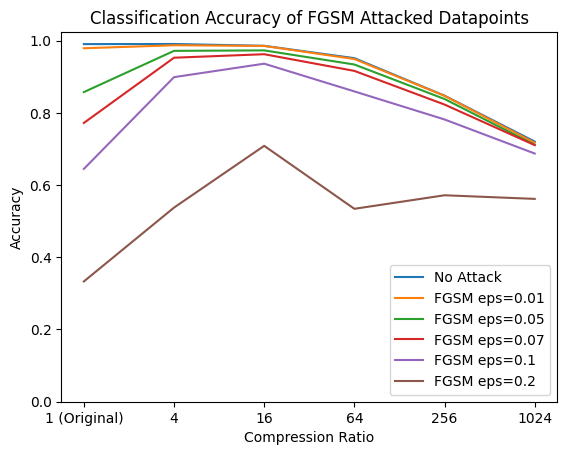

In [12]:
print(accuracies_no_attack)
print(accuracies_fgsm_attack_01)
print(accuracies_fgsm_attack_05)
print(accuracies_fgsm_attack_07)
print(accuracies_fgsm_attack_10)
print(accuracies_fgsm_attack_20)

layers = ["1 (Original)", "4", "16", "64", "256", "1024"]
plt.plot(layers, accuracies_no_attack, label="No Attack")
plt.plot(layers, accuracies_fgsm_attack_01, label="FGSM eps=0.01")
plt.plot(layers, accuracies_fgsm_attack_05, label="FGSM eps=0.05")
plt.plot(layers, accuracies_fgsm_attack_07, label="FGSM eps=0.07")
plt.plot(layers, accuracies_fgsm_attack_10, label="FGSM eps=0.1")
plt.plot(layers, accuracies_fgsm_attack_20, label="FGSM eps=0.2")

plt.title("Classification Accuracy of FGSM Attacked Datapoints")
plt.ylabel("Accuracy")
plt.xlabel("Compression Ratio")
plt.ylim(0)
plt.legend()

plt.savefig("./resources/mnist_fgsm_reconstructions.png")
plt.show()

[0.9903, 0.9906, 0.9856, 0.9514, 0.8475, 0.7204]
[0.9778, 0.9865, 0.984, 0.9489, 0.8494, 0.716]
[0.6967, 0.9697, 0.9715, 0.9335, 0.8398, 0.713]
[0.5339, 0.9525, 0.9636, 0.9265, 0.8298, 0.7105]
[0.4872, 0.9428, 0.9587, 0.9195, 0.8292, 0.7095]
[0.4827, 0.9406, 0.9584, 0.9233, 0.8256, 0.7097]


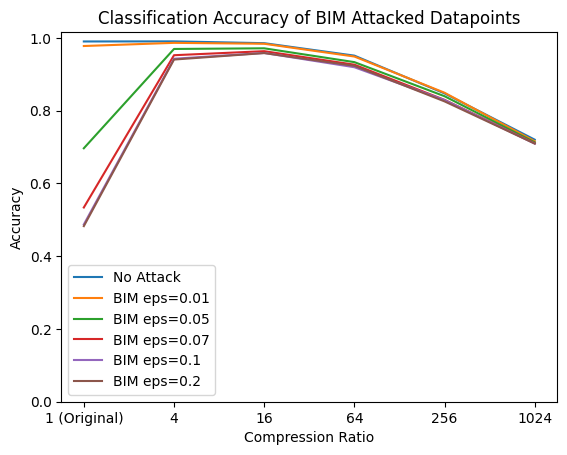

In [13]:
print(accuracies_no_attack)
print(accuracies_bim_attack_01)
print(accuracies_bim_attack_05)
print(accuracies_bim_attack_07)
print(accuracies_bim_attack_10)
print(accuracies_bim_attack_20)

layers = ["1 (Original)", "4", "16", "64", "256", "1024"]
plt.plot(layers, accuracies_no_attack, label="No Attack")
plt.plot(layers, accuracies_bim_attack_01, label="BIM eps=0.01")
plt.plot(layers, accuracies_bim_attack_05, label="BIM eps=0.05")
plt.plot(layers, accuracies_bim_attack_07, label="BIM eps=0.07")
plt.plot(layers, accuracies_bim_attack_10, label="BIM eps=0.1")
plt.plot(layers, accuracies_bim_attack_20, label="BIM eps=0.2")

plt.title("Classification Accuracy of BIM Attacked Datapoints")
plt.ylabel("Accuracy")
plt.xlabel("Compression Ratio")
plt.ylim(0)
plt.legend()
plt.savefig("./resources/mnist_bim_reconstructions.png")
plt.show()

[0.9903, 0.9906, 0.9856, 0.9514, 0.8475, 0.7204]
[0.9786, 0.9878, 0.9844, 0.9502, 0.8483, 0.7187]
[0.7038, 0.9722, 0.9723, 0.9332, 0.8361, 0.714]
[0.5468, 0.9625, 0.9682, 0.9225, 0.8291, 0.7124]
[0.4315, 0.9457, 0.96, 0.9079, 0.8142, 0.7062]


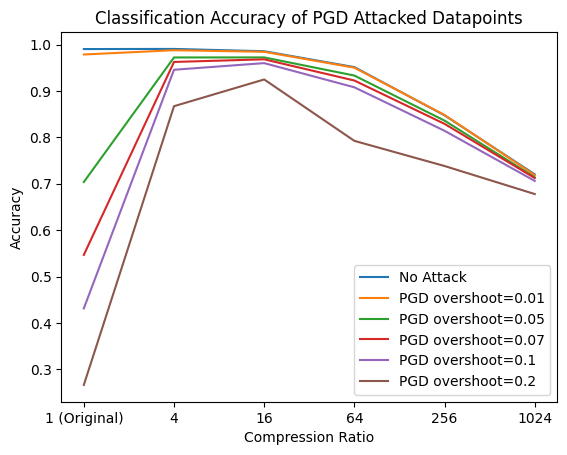

In [14]:
print(accuracies_no_attack)
print(accuracies_pgd_attack_01)
print(accuracies_pgd_attack_05)
print(accuracies_pgd_attack_07)
print(accuracies_pgd_attack_10)

layers = ["1 (Original)", "4", "16", "64", "256", "1024"]
plt.plot(layers, accuracies_no_attack, label="No Attack")
plt.plot(layers, accuracies_pgd_attack_01, label="PGD overshoot=0.01")
plt.plot(layers, accuracies_pgd_attack_05, label="PGD overshoot=0.05")
plt.plot(layers, accuracies_pgd_attack_07, label="PGD overshoot=0.07")
plt.plot(layers, accuracies_pgd_attack_10, label="PGD overshoot=0.1")
plt.plot(layers, accuracies_pgd_attack_20, label="PGD overshoot=0.2")

plt.title("Classification Accuracy of PGD Attacked Datapoints")
plt.ylabel("Accuracy")
plt.xlabel("Compression Ratio")
plt.legend()
plt.savefig("./resources/mnist_pgd_reconstructions.png")
plt.show()

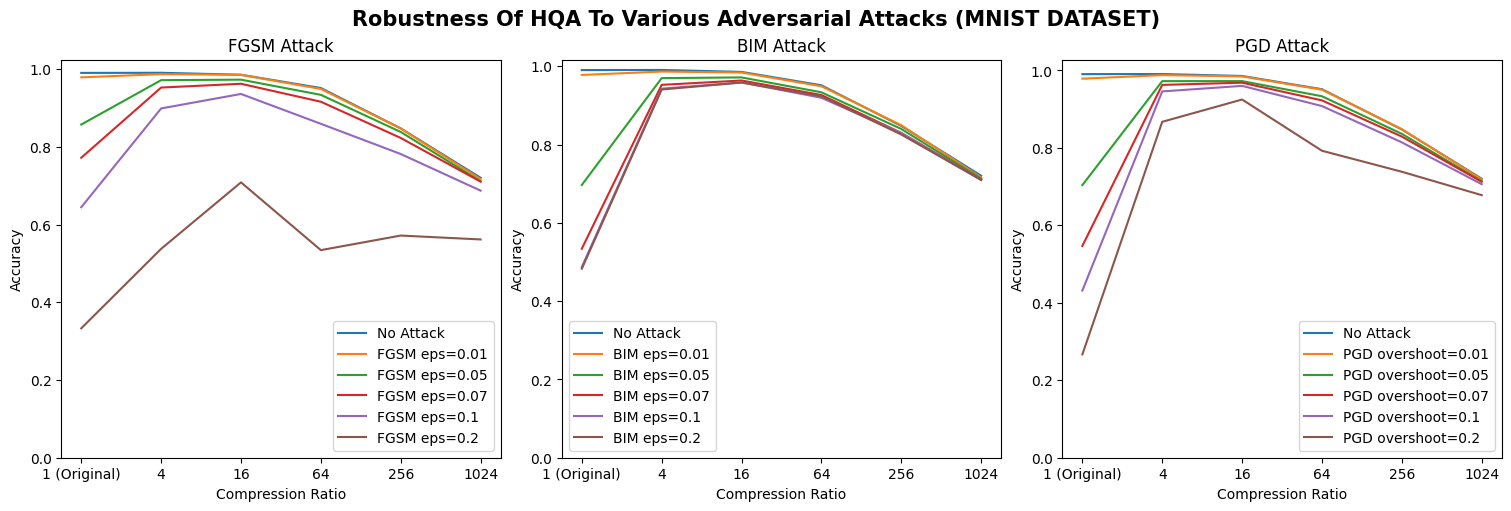

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3, constrained_layout=True, figsize=(15,5))
fig.suptitle("Robustness Of HQA To Various Adversarial Attacks (MNIST DATASET)", fontweight="bold", fontsize=15)
layers = ["1 (Original)", "4", "16", "64", "256", "1024"]
ax1.plot(layers, accuracies_no_attack, label="No Attack")
ax1.plot(layers, accuracies_fgsm_attack_01, label="FGSM eps=0.01")
ax1.plot(layers, accuracies_fgsm_attack_05, label="FGSM eps=0.05")
ax1.plot(layers, accuracies_fgsm_attack_07, label="FGSM eps=0.07")
ax1.plot(layers, accuracies_fgsm_attack_10, label="FGSM eps=0.1")
ax1.plot(layers, accuracies_fgsm_attack_20, label="FGSM eps=0.2")

ax1.set_title("FGSM Attack")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Compression Ratio")
ax1.set_ylim(0)
ax1.legend()

ax2.plot(layers, accuracies_no_attack, label="No Attack")
ax2.plot(layers, accuracies_bim_attack_01, label="BIM eps=0.01")
ax2.plot(layers, accuracies_bim_attack_05, label="BIM eps=0.05")
ax2.plot(layers, accuracies_bim_attack_07, label="BIM eps=0.07")
ax2.plot(layers, accuracies_bim_attack_10, label="BIM eps=0.1")
ax2.plot(layers, accuracies_bim_attack_20, label="BIM eps=0.2")

ax2.set_title("BIM Attack")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Compression Ratio")
ax2.set_ylim(0)
ax2.legend()

ax3.plot(layers, accuracies_no_attack, label="No Attack")
ax3.plot(layers, accuracies_pgd_attack_01, label="PGD overshoot=0.01")
ax3.plot(layers, accuracies_pgd_attack_05, label="PGD overshoot=0.05")
ax3.plot(layers, accuracies_pgd_attack_07, label="PGD overshoot=0.07")
ax3.plot(layers, accuracies_pgd_attack_10, label="PGD overshoot=0.1")
ax3.plot(layers, accuracies_pgd_attack_20, label="PGD overshoot=0.2")

ax3.set_title("PGD Attack")
ax3.set_ylabel("Accuracy")
ax3.set_xlabel("Compression Ratio")
ax3.set_ylim(0)
ax3.legend()
plt.savefig("./resources/mnist_attack_plots.png")

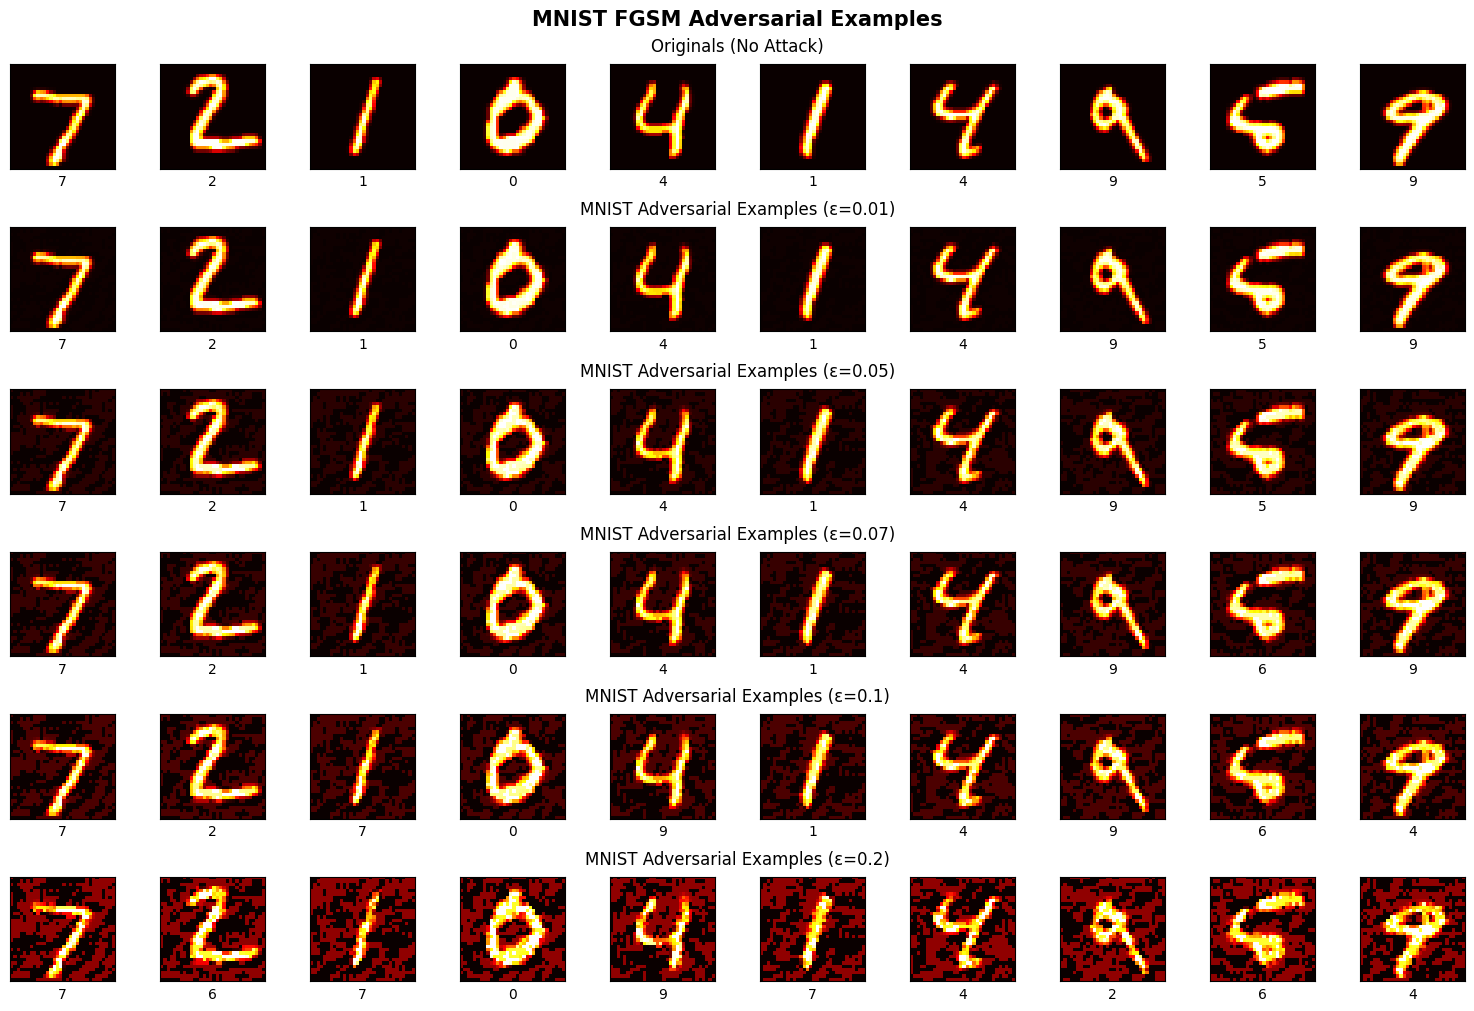

In [16]:
num_recons = 10

toImage = ToPILImage()
dataset = dl_test.dataset

epsilons = [0.01, 0.05, 0.07, 0.1, 0.2]

# create 3x1 subplots
fig, axs = plt.subplots(nrows=len(epsilons) + 1, ncols=1, constrained_layout=True, figsize=(15,10))
fig.suptitle('MNIST FGSM Adversarial Examples', fontweight="bold", fontsize=15)

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for row, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=num_recons)
    if row == 0:
        subfig.suptitle(f'Originals (No Attack)')
        y_pred = lenet_model(x.to(lenet_model.device))[:num_recons]
        y_pred = y_pred.argmax(axis=1)
        y_pred = list(map(lambda label : label.item(), y_pred))
        for ndx, x_original in enumerate(x[:num_recons]):
            axis = axs[ndx]
            original_img = toImage(x_original)
            axis.get_yaxis().set_ticks([])
            axis.get_xaxis().set_ticks([])
            axis.imshow(original_img, cmap='hot')
            axis.set_xlabel(y_pred[ndx])
    else:
        epsilon = epsilons[row - 1]
        subfig.suptitle(f'MNIST Adversarial Examples (ε={epsilon})')
        attack = torchattacks.FGSM(lenet_model, eps=epsilon)
        attacked_x = attack(x,y)
        attacked_y_pred = lenet_model(attacked_x.to(lenet_model.device))[:num_recons]
        attacked_y_pred = attacked_y_pred.argmax(axis=1)
        attacked_y_pred = list(map(lambda label : label.item(), attacked_y_pred))
        for img_ndx, x_attacked in enumerate(attacked_x[:num_recons]):
            axis = axs[img_ndx]
            attacked_img = toImage(x_attacked)
            axis.get_yaxis().set_ticks([])
            axis.get_xaxis().set_ticks([])
            axis.imshow(attacked_img, cmap='hot')
            axis.set_xlabel(attacked_y_pred[img_ndx])
plt.savefig("resources/mnist_fgsm.png")
plt.show()

In [17]:


"""
x, y = next(iter(dl_test))
img = x[0].numpy()
img = (255 * img).astype(np.uint8)
plt.imshow(img[0])
plt.show()
img = np.ascontiguousarray(img.swapaxes(0,2))
jpeg = simplejpeg.encode_jpeg(img, colorspace="GRAY")
dec = simplejpeg.decode_jpeg(jpeg, colorspace="GRAY").swapaxes(0,2)[0]
plt.imshow(dec)
plt.show()

print(np.prod(img.shape)/ len(jpeg) )
"""
x, y = next(iter(dl_test))
print(x.shape)
rec = reconstructWithJPEG(x)
print(rec.shape)

torch.Size([512, 1, 32, 32])
torch.Size([512, 1, 32, 32])


In [18]:
qualities = [100, 90, 75, 50, 25, 0]

def jpeg_reconstruct(quality=100):
    def _reconstruct(x, y):
        return reconstructWithJPEG(x, quality=quality)
    return _reconstruct

Y, Y_pred = get_preds(lenet_model, dl_test)
accuracy = accuracy_score(Y,Y_pred)
print("Original Data Classification Accuracy: ", accuracy)

for index, quality in enumerate(qualities):
    Y, Y_pred = get_preds(lenet_model, dl_test, transform=jpeg_reconstruct(quality=quality))
    accuracy = accuracy_score(Y,Y_pred)
    print(f"JPEG Reconstructions Classification Accuracy: (quality={quality})", accuracy)
    _, ratio = reconstructWithJPEG(next(iter(dl_test))[0], quality=quality, return_ratio = True)
    print(f"Ratio: ", ratio)

Original Data Classification Accuracy:  0.9905
JPEG Reconstructions Classification Accuracy: (quality=100) 0.9907
Ratio:  1.1906976744186046
JPEG Reconstructions Classification Accuracy: (quality=90) 0.9906
Ratio:  1.7474402730375427
JPEG Reconstructions Classification Accuracy: (quality=75) 0.9912
Ratio:  2.0357852882703775
JPEG Reconstructions Classification Accuracy: (quality=50) 0.9901
Ratio:  2.2555066079295156
JPEG Reconstructions Classification Accuracy: (quality=25) 0.99
Ratio:  2.4265402843601898
JPEG Reconstructions Classification Accuracy: (quality=0) 0.978
Ratio:  2.8444444444444446
